In [1]:
import sys
sys.path.append('/Users/c242587/Desktop/projects/git/ngboost')

# NGBoost: Natural Gradient Boosting for Probabilistic Prediction

ngboost is a Python library that implements Natural Gradient Boosting, as described in ["NGBoost: Natural Gradient Boosting for Probabilistic Prediction"](https://stanfordmlgroup.github.io/projects/ngboost/). It is built on top of [Scikit-Learn](https://scikit-learn.org/stable/), and is designed to be scalable and modular with respect to choice of proper scoring rule, distribution, and base learners.

Installation:

```
pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git
```

## Basic Usage

Probabilistic regression example on the Boston housing dataset:

In [2]:
from ngboost import NGBRegressor

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X, Y = load_boston(True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

ngb = NGBRegressor().fit(X_train, Y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, Y_test)
print('Test MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(Y_test).mean()
print('Test NLL', test_NLL)

[iter 0] loss=3.6107 val_loss=0.0000 scale=0.5000 norm=3.2676
[iter 100] loss=3.0419 val_loss=0.0000 scale=1.0000 norm=3.6587
[iter 200] loss=2.3984 val_loss=0.0000 scale=2.0000 norm=3.9767
[iter 300] loss=2.0206 val_loss=0.0000 scale=1.0000 norm=1.5899
[iter 400] loss=1.8514 val_loss=0.0000 scale=2.0000 norm=2.8957
Test MSE 7.687070548394566
Test NLL 2.488657963041638


Getting the estimated distributional parameters at a set of points is easy. This returns the predicted mean and standard deviation of the first five observations in the test set:

In [3]:
Y_dists[0:5].params

{'loc': array([16.42802035, 19.263839  , 23.36141796, 21.31705092, 22.18956048]),
 'scale': array([1.84392042, 1.56141862, 1.16001001, 1.41062929, 1.4968949 ])}

### Distributions

NGBoost can be used with a variety of distributions, broken down into those for regression (support on an infinite set) and those for classification (support on a finite set).

#### Regression Distributions

| Distribution | Parameters | Implemented Scores | Reference |
| --- | --- | --- | --- |
| `Normal` | `loc`, `scale` | `LogScore`, `CRPScore` | [`scipy.stats` normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) |
| `LogNormal` | `s`, `scale` | `LogScore`, `CRPScore` | [`scipy.stats` lognormal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html) |
| `Exponential` | `scale` | `LogScore`, `CRPScore` | [`scipy.stats` exponential](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html) |

Regression distributions can be used through the `NGBRegressor()` constructor by passing the appropriate class as the `Dist` argument. `Normal` is the default.

In [4]:
from ngboost.distns import Exponential, Normal

X, Y = load_boston(True)
X_reg_train, X_reg_test, Y_reg_train, Y_reg_test = train_test_split(X, Y, test_size=0.2)

ngb_norm = NGBRegressor(Dist=Normal, verbose=False).fit(X_reg_train, Y_reg_train)
ngb_exp = NGBRegressor(Dist=Exponential, verbose=False).fit(X_reg_train, Y_reg_train)

There are two prediction methods for `NGBRegressor` objects: `predict()`, which returns point predictions as one would expect from a standard regressor, and `pred_dist()`, which returns a distribution object representing the conditional distribution of $Y|X=x_i$ at the points $x_i$ in the test set.

In [5]:
ngb_norm.predict(X_reg_test)[0:5]

array([11.56299817, 33.32388263, 15.32580841, 15.67571114, 22.5911949 ])

In [6]:
ngb_exp.predict(X_reg_test)[0:5]

array([12.12638728, 33.71393985, 16.53011649, 15.259868  , 22.46128007])

In [7]:
ngb_exp.pred_dist(X_reg_test)[0:5].params

{'scale': array([12.12638728, 33.71393985, 16.53011649, 15.259868  , 22.46128007])}

##### Survival Regression

NGBoost supports analyses of right-censored data. Any distribution that can be used for regression in NGBoost can also be used for survival analysis in theory, but this requires the implementation of the right-censored version of the appropriate score. At the moment, `LogNormal` and `Exponential` have these scores implemented. To do survival analysis, use `NGBSurvival` and pass both the time-to-event (or censoring) and event indicator vectors to  `fit()`:

In [8]:
import numpy as np
from ngboost import NGBSurvival
from ngboost.distns import LogNormal

X, Y = load_boston(True)
X_surv_train, X_surv_test, Y_surv_train, Y_surv_test = train_test_split(X, Y, test_size=0.2)

# introduce administrative censoring to simulate survival data
T_surv_train = np.minimum(Y_train, 30) # time of an event or censoring
E_surv_train = Y_train > 30 # 1 if T[i] is the time of an event, 0 if it's a time of censoring

ngb = NGBSurvival(Dist=LogNormal).fit(X_surv_train, T_surv_train, E_surv_train)

[iter 0] loss=1.2437 val_loss=0.0000 scale=8.0000 norm=5.0343
[iter 100] loss=0.5528 val_loss=0.0000 scale=2.0000 norm=0.7513
[iter 200] loss=0.3122 val_loss=0.0000 scale=4.0000 norm=0.9052
[iter 300] loss=0.1859 val_loss=0.0000 scale=4.0000 norm=0.3818
[iter 400] loss=0.1131 val_loss=0.0000 scale=4.0000 norm=0.3063


#### Classification Distributions

| Distribution | Parameters | Implemented Scores | Reference |
| --- | --- | --- | --- |
| `k_categorical(K)` | `p0`, `p1`... `p{K-1}` | `LogScore` | [Categorical distribution on Wikipedia](https://en.wikipedia.org/wiki/Categorical_distribution) |
| `Bernoulli` | `p` | `LogScore` | [Bernoulli distribution on Wikipedia](https://en.wikipedia.org/wiki/Bernoulli_distribution) |

Classification distributions can be used through the `NGBClassifier()` constructor by passing the appropriate class as the `Dist` argument. `Bernoulli` is the default and is equivalent to `k_categorical(2)`.

In [9]:
from ngboost import NGBClassifier
from ngboost.distns import k_categorical, Bernoulli
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(True)
y[0:15] = 2 # artificially make this a 3-class problem instead of a 2-class problem
X_cls_train, X_cls_test, Y_cls_train, Y_cls_test  = train_test_split(X, y, test_size=0.2)

ngb_cat = NGBClassifier(Dist=k_categorical(3), verbose=False) # tell ngboost that there are 3 possible outcomes
_ = ngb_cat.fit(X_cls_train, Y_cls_train) # Y should have only 3 values: {0,1,2}

When using NGBoost for classification, the outcome vector `Y` must consist only of integers from 0 to K-1, where K is the total number of classes. This is consistent with the classification standards in sklearn.

`NGBClassifier` objects have three prediction methods: `predict()` returns the most likely class, `predict_proba()` returns the class probabilities, and `pred_dist()` returns the distribution object.

In [10]:
ngb_cat.predict(X_cls_test)[0:5]

array([1, 1, 1, 0, 1])

In [11]:
ngb_cat.predict_proba(X_cls_test)[0:5]

array([[5.03639908e-03, 9.94695784e-01, 2.67816806e-04],
       [2.53319895e-02, 9.74359423e-01, 3.08587121e-04],
       [5.03626649e-03, 9.94669599e-01, 2.94134594e-04],
       [9.86633776e-01, 1.22075299e-02, 1.15869433e-03],
       [5.03626649e-03, 9.94669599e-01, 2.94134594e-04]])

In [12]:
ngb_cat.pred_dist(X_cls_test)[0:5].params

{'p0': array([0.0050364 , 0.02533199, 0.00503627, 0.98663378, 0.00503627]),
 'p1': array([0.99469578, 0.97435942, 0.9946696 , 0.01220753, 0.9946696 ]),
 'p2': array([0.00026782, 0.00030859, 0.00029413, 0.00115869, 0.00029413])}

### Scores

NGBoost supports the log score (`LogScore`, also known as negative log-likelihood) and CRPS (`CRPScore`), although each score may not be implemented for each distribution. The score is specified by the `Score` argument in the constructor.

In [13]:
from ngboost.scores import LogScore, CRPScore

NGBRegressor(Dist=Exponential, Score=CRPScore, verbose=False).fit(X_reg_train, Y_reg_train)
NGBClassifier(Dist=k_categorical(3), Score=LogScore, verbose=False).fit(X_cls_train, Y_cls_train)

NGBClassifier(Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                                         max_features=None, max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         presort=False, random_state=None,
                                         splitter='best'),
              Dist=<class 'ngboost.distns.categorical.k_categorical.<locals>.Categorical'>,
              Score=<class 'ngboost.scores.LogScore'>, learning_rate=0.01,
              minibatch_frac=1.0, n_estimators=500, natural_gradient=True,
              random_state=RandomState(MT19937) at 0x10EF04258, tol=0.0001,
              verbose=False, verbose_eval=100)

### Base Learners

NGBoost can be used with any sklearn regressor as the base learner, specified with the `Base` argument. The default is a depth-3 regression tree.

In [14]:
from sklearn.tree import DecisionTreeRegressor

learner = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)

NGBSurvival(Dist=Exponential, Score=CRPScore, Base=learner, verbose=False).fit(X_surv_train, T_surv_train, E_surv_train)

NGBSurvival(Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                                       max_features=None, max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort=False, random_state=None,
                                       splitter='best'),
            Dist=<class 'ngboost.distns.distn.Distn.censor.<locals>.CensoredDist'>,
            Score=<class 'ngboost.scores.CRPScore'>, learning_rate=0.01,
            minibatch_frac=1.0, n_estimators=500, natural_gradient=True,
            random_state=RandomState(MT19937) at 0x10EF04258, tol=0.0001,
            verbose=False, verbose_eval=100)

### Other Arguments

The learning rate, number of estimators, and minibatch fraction are also easily adjusted:

In [15]:
NGBRegressor(n_estimators=100, learning_rate=0.01, minibatch_frac=0.5).fit(X_reg_train, Y_reg_train)

[iter 0] loss=3.7070 val_loss=0.0000 scale=0.5000 norm=3.6676


NGBRegressor(Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'),
             Dist=<class 'ngboost.distns.normal.Normal'>,
             Score=<class 'ngboost.scores.LogScore'>, learning_rate=0.01,
             minibatch_frac=0.5, n_estimators=100, natural_gradient=True,
             random_state=RandomState(MT19937) at 0x10EF04258, tol=0.0001,
             verbose=True, verbose_eval=100)

----

## Tuning

### Staged Prediction

All fit NGBoost objects support staged prediction.

In [16]:
ngb_cls = NGBClassifier(Dist=k_categorical(3), Score=LogScore, n_estimators=500, verbose=False).fit(X_cls_train, Y_cls_train)

For instance, to get the predictions on the first 5 examples after fitting 415 base learners, use:

In [17]:
preds = ngb_cls.staged_predict(X_cls_test)
preds[415][0:5]

array([1, 1, 1, 0, 1])

In [18]:
pred_dists = ngb_cls.staged_pred_dist(X_cls_test)
pred_dists[415][0:5].params

{'p0': array([0.00503665, 0.02403784, 0.00503652, 0.98663316, 0.00503652]),
 'p1': array([0.99469552, 0.97566934, 0.99466933, 0.0122081 , 0.99466933]),
 'p2': array([0.00026783, 0.00029282, 0.00029415, 0.00115874, 0.00029415])}

This is useful in conjunction with tracking errors on a validation set, which you can do by passing the `X_val` and `Y_val` arguments and then inspecting the `.best_val_loss_itr` instance attribute.

In [19]:
ngb = NGBRegressor()
ngb.fit(X_reg_train, Y_reg_train, X_val=X_reg_test, Y_val=Y_reg_test) # use a validation set instead of test set here in your own work
print(ngb.best_val_loss_itr)
best_preds = ngb.predict(X_reg_test, max_iter=ngb.best_val_loss_itr)

[iter 0] loss=3.6350 val_loss=3.6375 scale=0.5000 norm=3.3656
[iter 100] loss=3.0866 val_loss=3.1397 scale=1.0000 norm=3.8379
[iter 200] loss=2.4745 val_loss=2.6474 scale=2.0000 norm=4.1104
[iter 300] loss=2.0481 val_loss=2.5162 scale=2.0000 norm=3.2406
[iter 400] loss=1.8487 val_loss=2.7088 scale=1.0000 norm=1.4512
285


### Early Stopping

NGBoost also has early stopping. If an integer `early_stopping_rounds` and a validation set (`X_val`,`Y_val`) are passed to `fit()`, the algorithm will stop running after the validation loss has increased for `early_stopping_rounds` of consecutive iterations. 

In [19]:
_ = NGBRegressor().fit(X_reg_train, Y_reg_train, X_val=X_reg_test, Y_val=Y_reg_test, early_stopping_rounds=2)

[iter 0] loss=3.6344 val_loss=3.6350 scale=0.5000 norm=3.3922
[iter 100] loss=3.0970 val_loss=3.0936 scale=1.0000 norm=3.9017
[iter 200] loss=2.4638 val_loss=2.5476 scale=2.0000 norm=4.1555
== Early stopping achieved.
== Best iteration / VAL 289 (val_loss=2.3798)


### Using `sklearn` Model Selection

`sklearn` methods are compatible with NGBoost.

In [20]:
from sklearn.model_selection import GridSearchCV

b1 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=2)
b2 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=4)

param_grid = {
    'n_estimators': [20, 50],
    'minibatch_frac': [1.0, 0.5],
    'Base': [b1, b2]
}

ngb = NGBRegressor(Dist=Normal, verbose=False)

grid_search = GridSearchCV(ngb, param_grid=param_grid, cv=5)
grid_search.fit(X_reg_train, Y_reg_train)
print(grid_search.best_params_)

{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best'), 'minibatch_frac': 1.0, 'n_estimators': 20}


---

## Model Interpretation

We caution users [against trying to interpret](https://www.google.com/search?q=mythos+of+interpretability&rlz=1C5CHFA_enUS831US831&oq=mythos+of+in&aqs=chrome.0.0j69i57j0l6.2088j0j7&sourceid=chrome&ie=UTF-8) too much from any machine learning model, but NGBoost does provide methods to interpret models fit with regression tree base learners. Since each parameter in the distribution is fit by a separate sequence of learners, there will be multiple model interpretation results, one for each parameter. The default distribution used is normal distribution so the following example shows results for the `loc` and `scale` parameters.

### Feature Importance

In [24]:
ngb = NGBRegressor(verbose=False).fit(X_reg_train, Y_reg_train)

## Feature importance for loc trees
feature_importance_loc = ngb.feature_importances_[0]

## Feature importance for scale trees
feature_importance_scale = ngb.feature_importances_[1]

Text(0.5, 1.0, 'scale param')

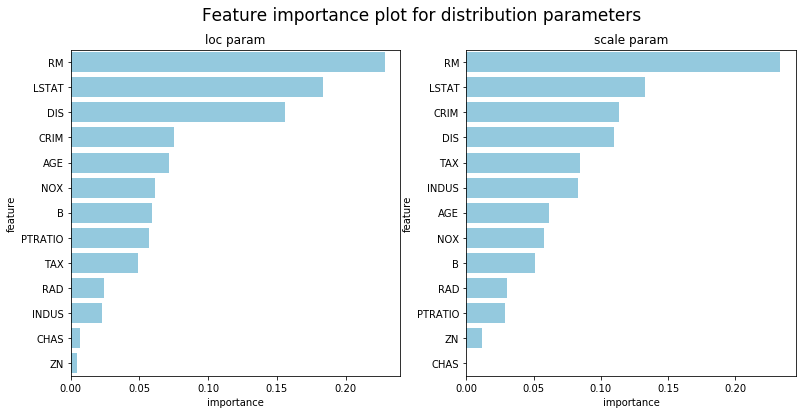

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_loc = pd.DataFrame({'feature':load_boston()['feature_names'], 
                       'importance':feature_importance_loc})\
    .sort_values('importance',ascending=False)
df_scale = pd.DataFrame({'feature':load_boston()['feature_names'], 
                       'importance':feature_importance_scale})\
    .sort_values('importance',ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
fig.suptitle("Feature importance plot for distribution parameters", fontsize=17)
sns.barplot(x='importance',y='feature',ax=ax1,data=df_loc, color="skyblue").set_title('loc param')
sns.barplot(x='importance',y='feature',ax=ax2,data=df_scale, color="skyblue").set_title('scale param')

### SHAP

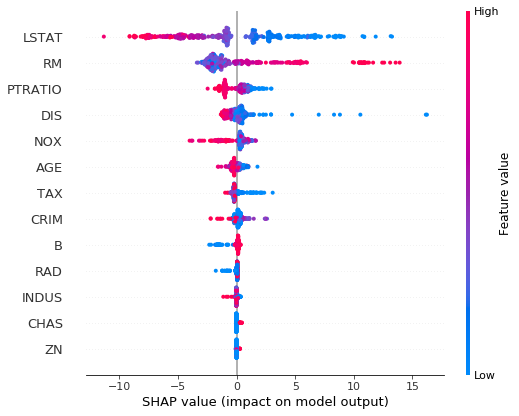

In [27]:
import shap
shap.initjs()

## SHAP plot for loc trees
explainer = shap.TreeExplainer(ngb, model_output=0) # use model_output = 1 for scale trees
shap_values = explainer.shap_values(X_reg_train)
shap.summary_plot(shap_values, X_reg_train, feature_names=load_boston()['feature_names'])

----

## Adding Functionality

As you work with NGBoost, you may want to experiment with distributions or scores that are not yet supported. Here we will walk through the process of implementing a new distribution or score.

### Adding Distributions

The first order of business is to write the class for your new distribution. The distribution class must subclass the appropriate distribution type (either `RegressionDistn` or `ClassificationDistn`) and must implement methods for `fit()` and `sample()`. The scores compatible with the distribution should be stored in a class attribute called `score` and the number of parameters in an class attribute n_params. The class must also store the (internal) distributional parameters in a `_params` instance attribute. Additionally, regression distributions must implement a `mean()` method to support point prediction.

We'll use the Laplace distribution as an example. The Laplace distribution has PDF $\frac{1}{2b} e^{-\frac{|x-\mu|}{b}}$ with user-facing parameters $\mu \in \mathbb{R}$ and $b > 0$, which we will call `loc` and `scale` to conform to the [`scipy.stats` implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.laplace.html). 

In NGBoost, all parameters must be represented internally in $\mathbb R$, so we need to reparametrize $(\mu, b)$ to, for instance, $(\mu, \log(b))$. The latter are the parameters we need to work with when we initialize a `Laplace` object and when implement the score.

In [28]:
from scipy.stats import laplace as dist
import numpy as np
from ngboost.distns.distn import RegressionDistn
from ngboost.scores import LogScore

class LaplaceLogScore(LogScore): # will implement this later
    pass

class Laplace(RegressionDistn):

    n_params = 2
    scores = [LaplaceLogScore] # will implement this later

    def __init__(self, params):
        # save the parameters
        self._params = params
        
        # create other objects that will be useful later
        self.loc = params[0]
        self.logscale = params[1]
        self.scale = np.exp(params[1]) # since params[1] is log(scale)
        self.dist = dist(loc=self.loc, scale=self.scale)

    def fit(Y):
        m, s = dist.fit(Y) # use scipy's implementation
        return np.array([m, np.log(s)])

    def sample(self, m):
        return np.array([self.dist.rvs() for i in range(m)])
    
    def __getattr__(self, name): # gives us access to Laplace.mean() required for RegressionDist.predict()
        if name in dir(self.dist):
            return getattr(self.dist, name)
        return None
    
    @property
    def params(self):
        return {'loc':self.loc, 'scale':self.scale}

The `fit()` method is a class method that takes a vector of observations and fits a marginal distribution. Meanwhile, `sample()` should return a $m$ samples from $P(Y|X=x)$, each of which is a vector of `len(Y)`.

Here we're taking advantage of the fact that `scipy.stats` already has the Laplace distribution implemented so we can steal its `fit()` method and put a thin wrapper around `rvs()` to get samples. We also use `__getattr__()` on the internal `scipy.stats` object to get access to its `mean()` method.

Lastly, we write a convenience method `params()` that, when called, returns the distributional parameters as the user expects to see them, i.e. $(\mu, b)$, not $(\mu, \log b)$.

#### Implementing a Score for our Distribution

Now we turn our attention to implementing a score that we can use with this distribution. We'll use the log score as an example. 

All implemented scores should subclass the appropriate score and implement three methods: 

* `score()` : the value of the score at the current parameters, given the data `Y`
* `d_score()` : the derivative of the score at the current parameters, given the data `Y`
* `metric()` : the value of the Riemannian metric at the current parameters
    

In [29]:
class LaplaceLogScore(LogScore): 
    
    def score(self, Y):
        return -self.dist.logpdf(Y)

    def d_score(self, Y):
        D = np.zeros((len(Y), 2)) # first col is dS/d𝜇, second col is dS/d(log(b))
        D[:, 0] = np.sign(self.logscale - Y)/self.scale
        D[:, 1] = 1 - np.abs(self.logscale - Y)/self.scale
        return D

Notice that the attributes of an instance of `Laplace` are referenced using the `self.attr` notation even though we haven't said these will be attributes of the `LaplaceLogScore` class. When a user asks NGBoost to use the `Laplace` distribution with the `LogScore`, NGBoost will first find the implmentation of the log score that is compatible with `Laplace`, i.e. `LaplaceLogScore` and dynamically create a new class that has both the attributes of the distribution and the appropriate implementation of the score.

The derivatives with respect to [$\log b$](https://www.wolframalpha.com/input/?i=d%2Fdb+-log%281%2F%282e%5Eb%29+e%5E%28-%7Cx-a%7C%2Fe%5Eb%29%29) and [$\mu$](https://www.wolframalpha.com/input/?i=d%2Fda+-log%281%2F%282e%5Eb%29+e%5E%28-%7Cx-a%7C%2Fe%5Eb%29%29) are easily derived using, for instance, WolframAlpha.

In this example we won't bother implementing `metric()`, which would return the current Fisher Information. The reason is that the NGBoost implmentation of `LogScore` has a default `metric()` method that uses a Monte Carlo method to approximate the Fisher Information using the `gradient()` method and the distribution's `sample()` method (that's why we needed to implement `sample()`). By inhereting from `LogScore()`, not only can NGBoost find our implementation for the Laplace distribution, it can also fall back on the defualt `metric()` method. 

CRPScore does not have a default metric method, so implementations of that score should have an explicit `metric()` method. The math is sometimes tricky to derive the Riemannian metrics. Also note that NGBoost will run faster if you provide an explicit implementation of `metric()` for implementations of `LogScore`.

Putting it all together:

In [30]:
class LaplaceLogScore(LogScore): 
    
    def score(self, Y):
        return -self.dist.logpdf(Y)

    def d_score(self, Y):
        D = np.zeros((len(Y), 2)) # first col is dS/d𝜇, second col is dS/d(log(b))
        D[:, 0] = -np.sign(self.logscale - Y)/self.scale
        D[:, 1] = 1 - np.abs(self.logscale - Y)/self.scale
        return D

class Laplace(RegressionDistn):

    n_params = 2
    scores = [LaplaceLogScore] 

    def __init__(self, params):
        # save the parameters
        self._params = params
        
        # create other objects that will be useful later
        self.loc = params[0]
        self.logscale = params[1]
        self.scale = np.exp(params[1]) # since params[1] is log(scale)
        self.dist = dist(loc=self.loc, scale=self.scale)

    def fit(Y):
        m, s = dist.fit(Y) # use scipy's implementation
        return np.array([m, np.log(s)])

    def sample(self, m):
        return np.array([self.dist.rvs() for i in range(m)])
    
    def __getattr__(self, name): # gives us access to Laplace.mean() required for RegressionDist.predict()
        if name in dir(self.dist):
            return getattr(self.dist, name)
        return None
    
    @property
    def params(self):
        return {'loc':self.loc, 'scale':self.scale}

And we can test our method:

In [31]:
ngb = NGBRegressor(Dist=Laplace, Score=LogScore).fit(X_reg_train, Y_reg_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, Y_test)
print('Test MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(Y_test).mean()
print('Test NLL', test_NLL)

[iter 0] loss=3.5775 val_loss=0.0000 scale=0.5000 norm=5.3739
[iter 100] loss=3.3302 val_loss=0.0000 scale=0.2500 norm=1.4877
[iter 200] loss=3.3254 val_loss=0.0000 scale=0.0156 norm=0.0867
[iter 300] loss=3.3253 val_loss=0.0000 scale=0.0000 norm=0.0001
[iter 400] loss=3.3253 val_loss=0.0000 scale=0.0000 norm=0.0001
Test MSE 54.27592602843368
Test NLL 3.339154245113412


Dig into the source of `ngboost.distns` to find more examples. If you write and test your own distribution, please contribute it to NGBoost by making a pull request!

#### Censored Scores

You can make your distribution suitable for use in surival analysis if you implement a censored version of the score. The signature for the `score()`, `d_score()` and `metric()` methods should be the same, but they should expect `Y` to be indexable into two arrays like `E, T = Y["Event"], Y["Time"]`. Furthermore, any censored scores should be linked to the distribution class definition via a class attribute called `censored_scores` instead of `scores`. 

Since censored scores are more general than their standard counterparts (fully observed data is a specific case of censored data), if you implement a censored score in NGBoost, it will automatically become available as a useable score for standard regression analysis. No need to implement the regression score seperately or register it in the `scores` class attribute.

### Adding Scores

We've seen how to *implement* an existing score for a new distribution, but making a new score altogether in NGBoost is also easy: just make a new class that subclasses `Score`:

In [32]:
from ngboost.scores import Score

class SphericalScore(Score):
    pass

That's it. Distribution-specific implemenations of this score (e.g. `LaplaceSphericalScore`) should subclass `SphericalScore`. The implementations of `LogScore` and `CRPScore` are in `ngboost.scores` for reference.